In [85]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.generators import MorseGenerator

In [10]:
labels_dir = '../'
data_dir = '../data/melspec_nfft512_nc64'

full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [11]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


In [12]:
device = 'cpu'

In [13]:
n_epochs = 30


n_pooled_blocks = 4
n_head_blocks = 2
batch_size = 128
lr = 0.005
# n_blocks = 12
inner_size = 64
# exp_gamma = 0.8
step_gamma = 0.359
p_dropout = 0.165

model = MySomething(n_pooled_blocks = n_pooled_blocks, n_head_blocks = n_head_blocks,
                    input_size = 64, inner_size = inner_size, output_size = dictionary_size + 1,
                    p_dropout = p_dropout).to(device)
model.load_state_dict(torch.load('../models/cnn_ctc/best_params_retrained_30ep.pt', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
def batch_text_transform(texts):
    vecs, lengths = vectorizer.batch_text_transform(texts, pad_value=pad_value)
    return vecs + 1, lengths

In [16]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
print(train_index.shape, val_index.shape)
val_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[val_index]['id'])))))
val_labels = list(full_train_df.iloc[val_index]['message'])
valset = ListDataset(val_features, val_labels)
print(len(valset))

(25000,) (5000,)


5000it [00:30, 166.00it/s]

5000


In [ ]:
generator = (valset[i] for i in range(250))

val_ctc_probs = []
val_ctc_labels = []

model.eval()
with torch.no_grad():
    for features, labels in tqdm(generator):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        val_ctc_probs.append(probs)
        val_ctc_labels.append(labels)

print(len(val_ctc_probs))

250it [00:00, 304.78it/s]

250


In [29]:
distance_buffer = []
for prob, label in zip(tqdm(val_ctc_probs), val_ctc_labels):
    seqs, likelihood = LongCTCSampler.sample(prob, beam_size=10)
    text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
    # print(text, label)
    decoded_message = text
    dist = Levenshtein.distance(decoded_message, label)
    # print(dist)
    distance_buffer.append(dist)
val_mean_dist = np.mean(distance_buffer)
print(val_mean_dist)

100%|██████████| 250/250 [00:13<00:00, 18.39it/s]

0.516


# inference

In [30]:
test_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(test_df['id'])))))
# val_labels = list(full_train_df.iloc[val_index]['message'])
# valset = ListDataset(val_features, val_labels)
print(len(test_features))

5000it [00:33, 147.54it/s]

5000


In [32]:
test_ctc_probs = []
# val_ctc_labels = []

model.eval()
with torch.no_grad():
    for features in tqdm(test_features):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        test_ctc_probs.append(probs)
        # val_ctc_labels.append(labels)

print(len(test_ctc_probs))

100%|██████████| 5000/5000 [00:12<00:00, 387.75it/s]

5000


In [37]:
test_decoded_list = []
for prob in tqdm(test_ctc_probs):
    seqs, likelihood = LongCTCSampler.sample(prob, beam_size=10)
    text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
    test_decoded_list.append(text)
print(len(test_decoded_list))

100%|██████████| 5000/5000 [07:18<00:00, 11.40it/s]

5000


In [82]:
star_features = test_features[-17:]
star_pred_messages = test_decoded_list[-17:]
actual_morse = [''] * 17
print(len(star_features))
print(star_features[0].shape)



17
torch.Size([64, 3001])


In [83]:
def show_star_message(idx, start=0, end=1):
    message = star_pred_messages[idx]
    print(message)
    print(encode_to_morse(message))
    plt.figure(figsize=(18, 10), dpi=80)
    length = star_features[0].shape[1]
    # [:, :int(length * end)]
    start_pos = int(length * start)
    end_pos =int(length * end)
    plt.imshow(star_features[idx], aspect=5)
    plt.plot([start_pos, start_pos], [0, 64], color='red')
    plt.plot([end_pos, end_pos], [0, 64], color='aqua')
    plt.show()
    plt.figure(figsize=(18, 10), dpi=80)
    plt.imshow(star_features[idx][:, start_pos:end_pos], aspect=5)
    plt.show()

ДАМИНАМТ ДОТИ РСЫСАМЦИ
АМАМТОТСЦАМК
.- -- .- -- - --- - ... -.-. .- -- -.-


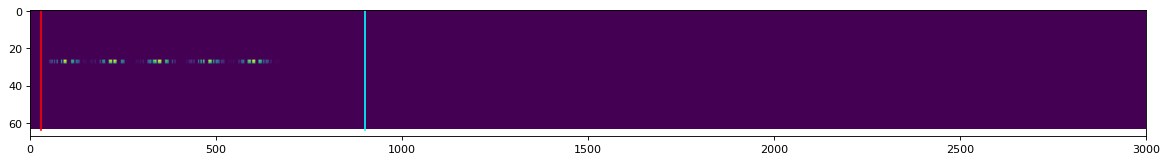

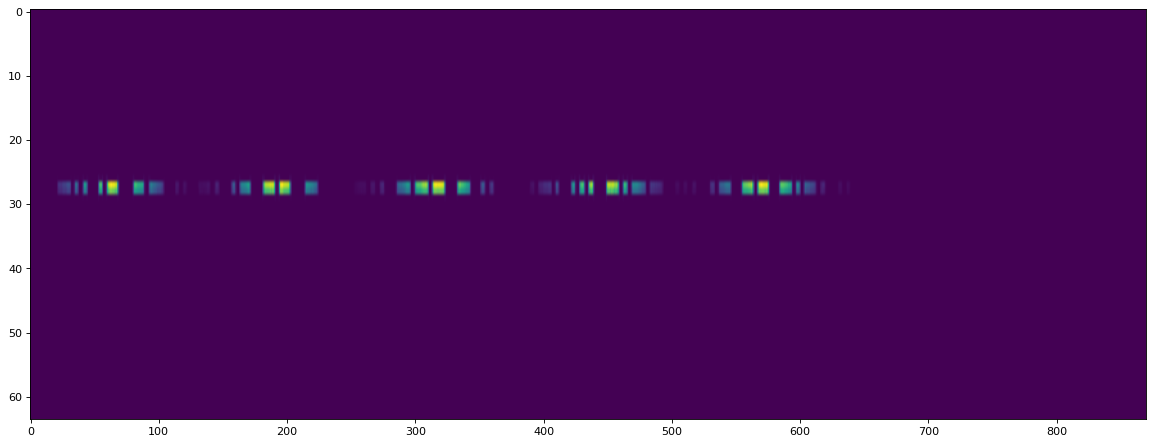

In [87]:
idx = 0
actual_morse[idx] = '-.. .- -- .. -. .- -- - / -.. --- - .. / .-. ... -.-- ... .- -- -.-. ..'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.01, end=0.3)

ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
ЬСВЕНТИЯМЮНЯИЫММЫНГЗ
-..- ... .-- . -. - .. .-.- -- ..-- -. .-.- .. -.-- -- -- -.-- -. --. --..


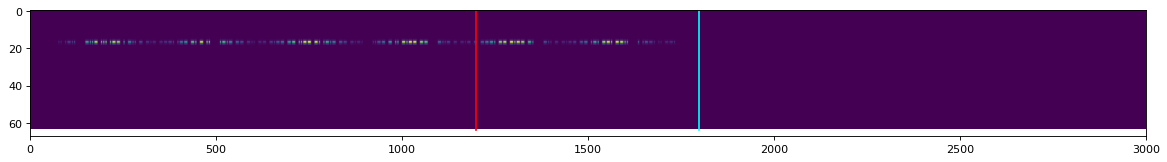

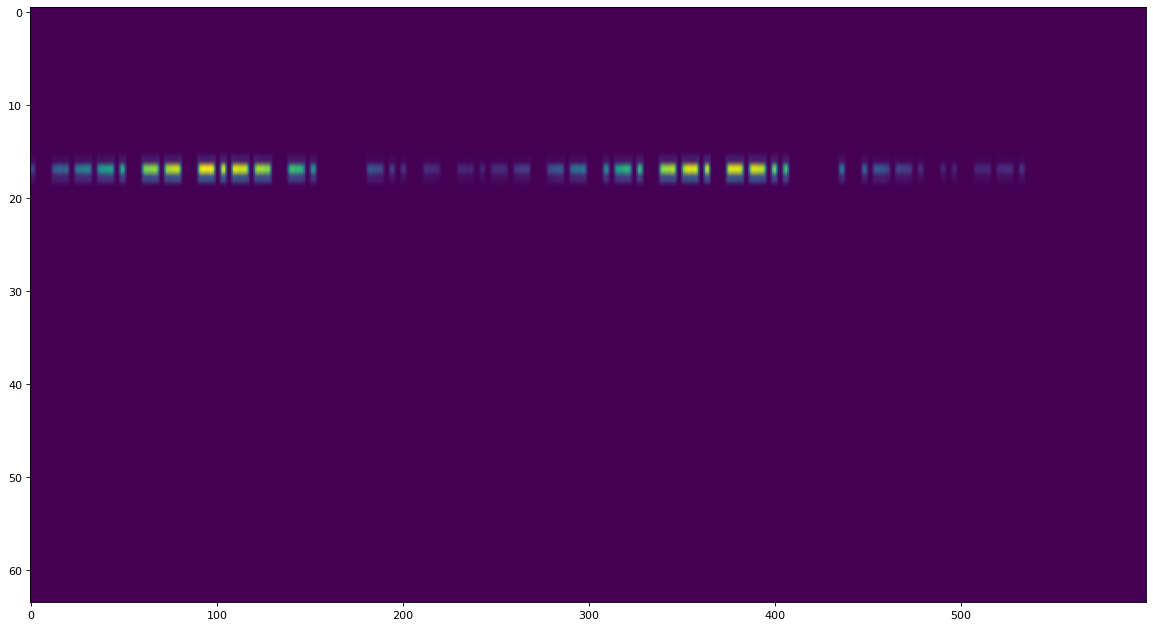

In [92]:
idx = 1
actual_morse[idx] = '.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.4, end=0.6)

АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА
НХМЕГРВДАМКШНИНЖ
-. .... -- . --. .-. .-- -.. .- -- -.- ---- -. .. -. ...-


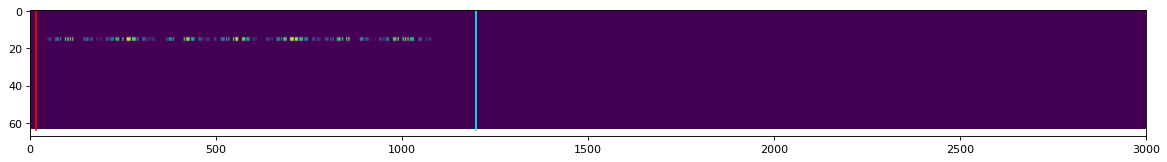

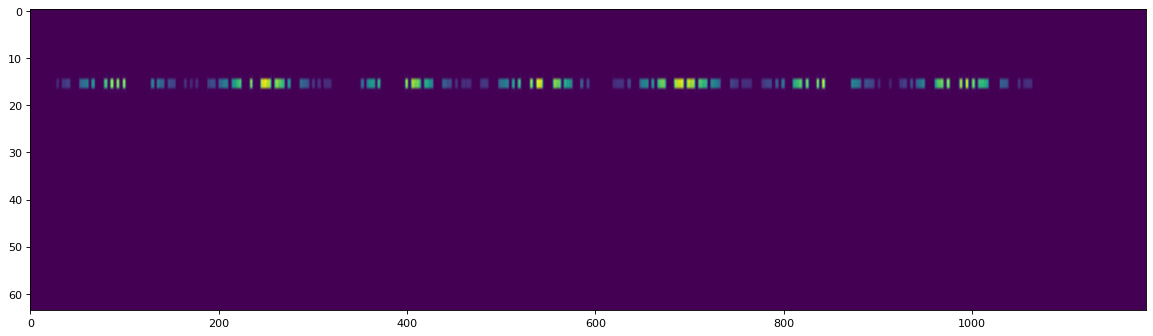

In [97]:
idx = 2
actual_morse[idx] = '.- -. .... / .-- ... --- . --. -..- / .-. / .-- -.- - -.. .- -- .. / -. -.- ---- -- -.. -. .. / --. . -.- -. ...- - .-'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.005, end=0.4)

ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНХНУСИ
ЬСООВНЮ
-..- ... --- --- .-- -. ..--


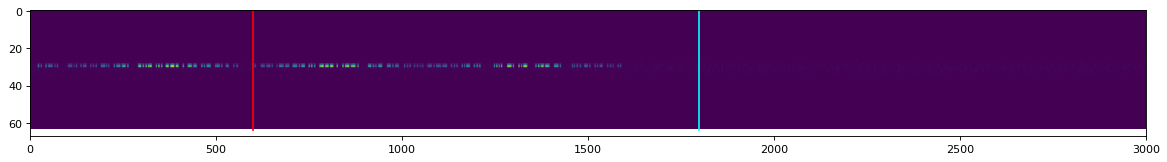

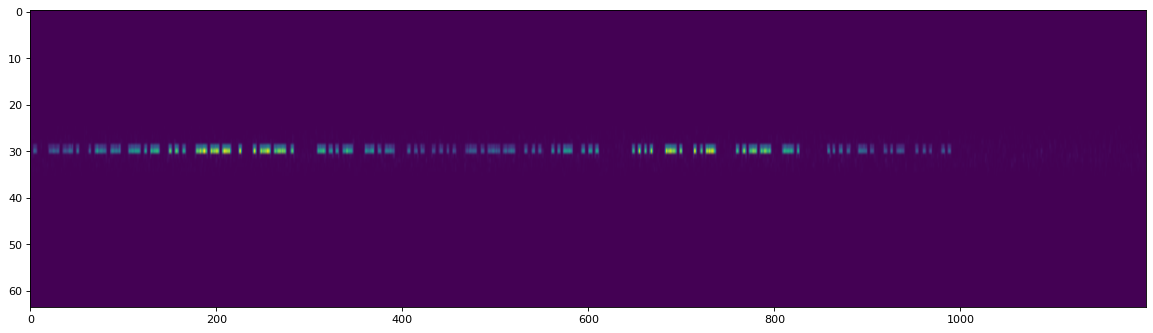

In [103]:
idx = 3
actual_morse[idx] = '.. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- -. - .. / .. --. .-- -.- ... --- . .--. / -..- -.- ... .... -.-- ... ..- ... / .... -. ..- / ..-- -. / .... -. .... -. ..- ... ..'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0.2, end=0.6)

ЕТЬТКП ДСЯНКМЫОЦ ИМК
ЬТКПЯНКМЫОЦМК
-..- - -.- .--. .-.- -. -.- -- -.-- --- -.-. -- -.-


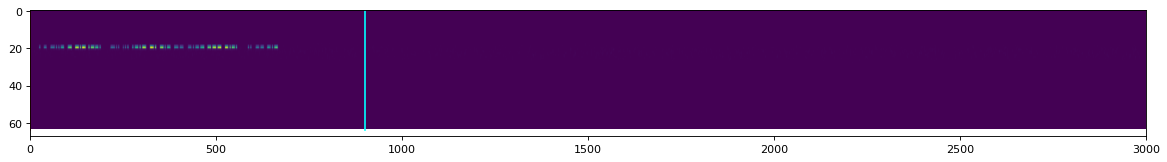

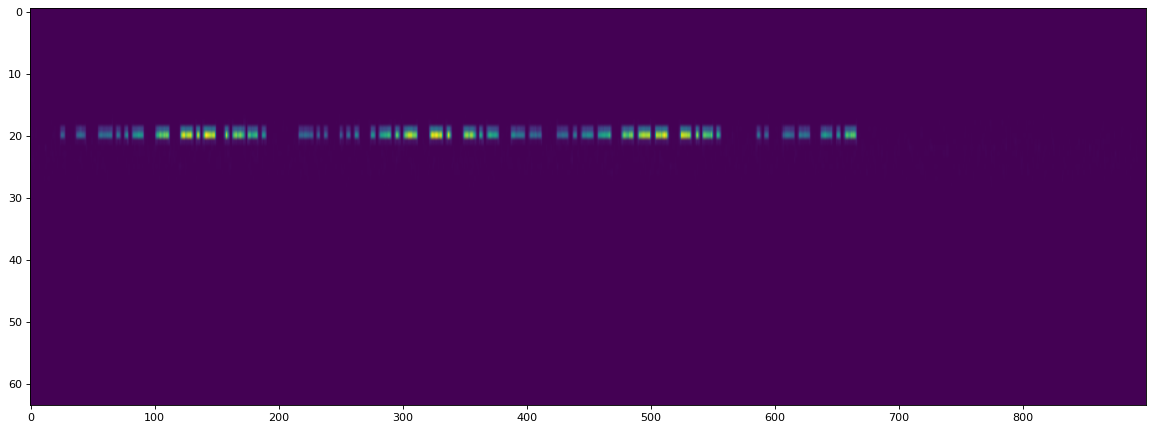

In [106]:
idx = 4
actual_morse[idx] = '. - -..- - -.- .--. / -.. ... .-.- -. -.- -- -.-- --- -.-. / .. -- -.-'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0, end=0.3)

КНОЬКМ СОЕНЫМОП ЬСЮНВМ
ЬКМ СОП ЬМ
-..- -.- -- / ... --- .--. / -..- --


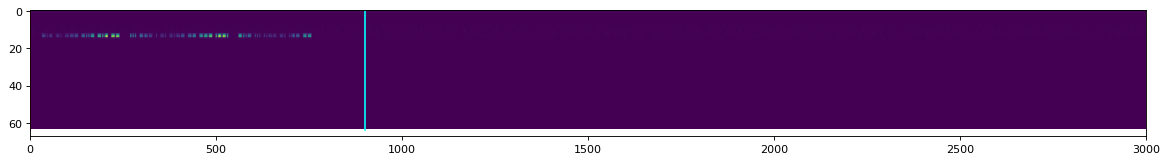

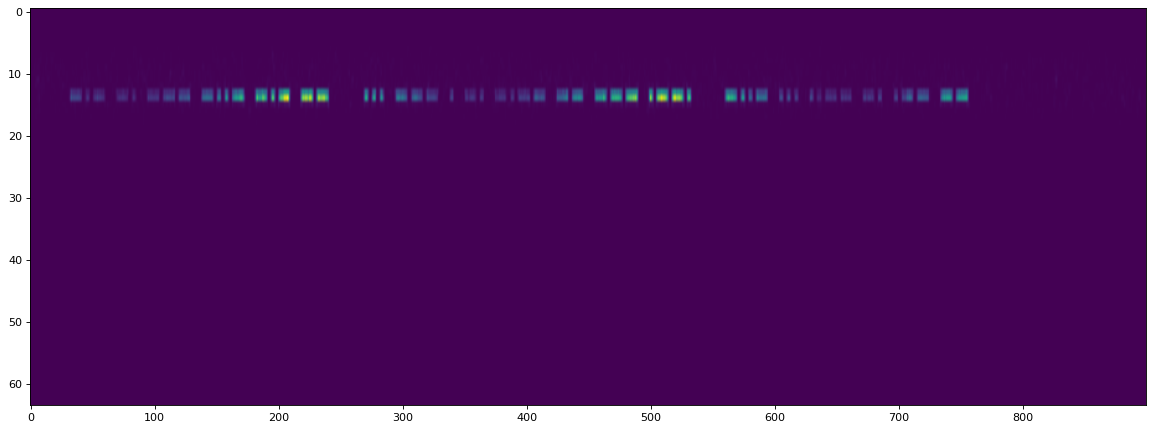

In [109]:
idx = 5
actual_morse[idx] = '-.- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / -..- ... ..-- -. .-- --'
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0, end=0.3)

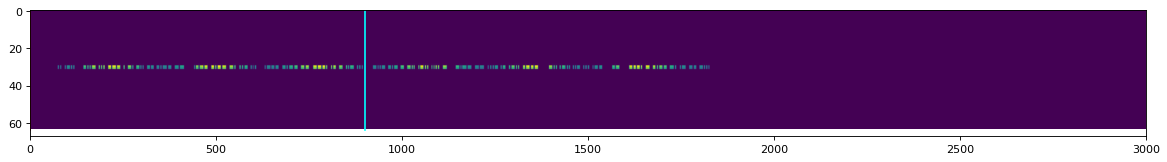

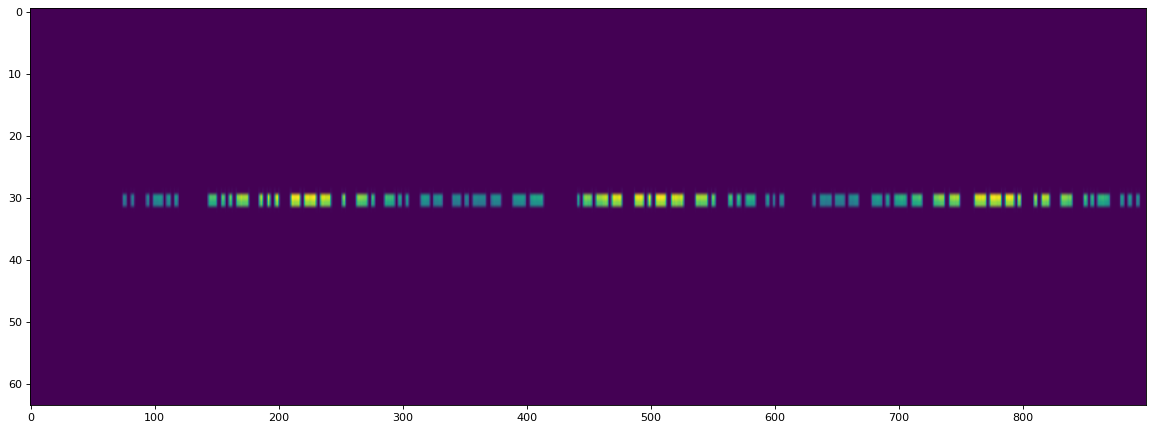

In [112]:
idx = 6
actual_morse[idx] = ''
print(decode_from_morse(actual_morse[idx]))
show_star_message(idx, start=0, end=0.3)

In [113]:
text = ' '.join([decode_from_morse(morse) for morse in actual_morse])
text

'ДАМИНАМТ ДОТИ РСЫСАМЦИ ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНХНУСИ ЕТЬТКП ДСЯНКМЫОЦ ИМК КНОЬКМ СОЕНЫМОП ЬСЮНВМ           '

In [38]:
# decoded_list = []
# model.eval()
# for features in tqdm(test_features):
#     with torch.no_grad():
#         outs = model(features[None].to(device))
#         probs = F.softmax(outs.squeeze(), dim=0).to('cpu')
#     seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
#     text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
#     decoded_list.append(text)